## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pandas as pd

import time

import random

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [2]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

import sklearn

import manifolder as mr
from manifolder import helper as mh


In [3]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [4]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [5]:
import pickle
#Load Data
segments = np.load('themis\segments-newdata-all.npy')

# Load Labels
labels = np.load('themis\labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [6]:
def featureEmbedding(featInd,data_raw,labels):
    # loop through the data, breaking out the clusters
    # i will always point to the NaN (blank line) in the dataframe,
    # and values [i-1440:i] is the snipped

    snippet_len = 1440

    # collect all line breaks (blank lines) in csv file
    #lineBreaks = [0]
    #for i in range(data_raw.shape[0]):
    #    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
    #        lineBreaks.append(i)    
    #lineBreaks.append(data_raw.shape[0])
    #
    #num_snippet = len(lineBreaks)-1


    # callect the snippets into two groups, one for each goal (target) value, 0 or 1
    # these can be easily merged
    zs_0 = []
    zs_1 = []

    locallabel_0 = []
    locallabel_1 = []
    snippet_index = 0;

    reduce_dimension = True

    for i in range(snippet_len,data_raw.shape[0],snippet_len+1):
        # copy the snipped, excluding the last value, which is the goal
        snippet = data_raw[i-snippet_len:i,:-1]

        if reduce_dimension:
            snippet = snippet[:,featInd]
            snippet = snippet.reshape(snippet_len,len(featInd))

        # grab the goal value from the first row of each snippet
        goal = data_raw[i-snippet_len,-1]

        # check to make sure each snippet does not contain NaN
        # (should not, if parsing is correct)
        assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'

        snippetlabel = np.zeros(snippet_len)
        if goal == 1:
            bmin = int(bboxes[snippet_index][0][0])
            bmax = int(bboxes[snippet_index][0][2])
            snippetlabel[bmin:bmax] = 1

        if goal == 0:
            zs_0.append( snippet )
            locallabel_0.append( snippetlabel )
        elif goal == 1:
            zs_1.append( snippet )
            locallabel_1.append( snippetlabel )
        else:
            assert False, 'value of goal not understood'

        snippet_index = snippet_index + 1;


    # shuffle this lists; this should not strictly be necessary, if all the data is being used,
    # but prevents biases when shortening the list

    c0 = list(zip(zs_0, locallabel_0))
    random.shuffle(c0)
    zs_0, locallabel_0 = zip(*c0)
    zs_0 = list(zs_0)
    locallabel_0 = list(locallabel_0)

    c1 = list(zip(zs_1, locallabel_1))
    random.shuffle(c1)
    zs_1, locallabel_1 = zip(*c1)
    zs_1 = list(zs_1)
    locallabel_1 = list(locallabel_1)

    shorten_data = False

    if shorten_data:
        zs_0 = zs_0[:20]
        zs_1 = zs_1[:20]
        locallabel_0 = locallabel_0[:20]
        locallabel_1 = locallabel_1[:20]

    zs = zs_0 + zs_1
    locallabel = locallabel_0 + locallabel_1
    z_breakpoint = len(zs_0)


    # data has been parsed, now run Manifolder
    dim=8
    H = 160
    step_size = 20
    nbins = 10
    ncov = 10

    start_time = time.time()

    # create manifolder object
    manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov)

    # add the data, and fit (this runs all the functions)
    manifolder.fit_transform(zs, parallel=False)

    elapsed_time = time.time() - start_time
    print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)

    manifolder.zs_0 = zs_0
    manifolder.zs_1 = zs_1
    manifolder.locallabel = locallabel
    manifolder.step_size = step_size
    return manifolder

In [7]:
def nearestNeighborClassification_repeated(manifolder, test_size):
    
    zs_0 = manifolder.zs_0
    zs_1 = manifolder.zs_1
    locallabel = manifolder.locallabel
    
    locallabel_downsample = np.empty(0, float)
    for i in range(len(locallabel)):
        x = locallabel[i]
        x = x[0:x.shape[0]-manifolder.H]
        x = x[::manifolder.step_size]

        locallabel_downsample = np.append(locallabel_downsample,x,0)

    Psi = manifolder.Psi[:,0:manifolder.Dim]
    
    numIter = 100
    threshold_store = np.zeros(numIter)
    CM_store = np.zeros((2,2,numIter))
    for iter in range(numIter):
        val_size = 0

        snippet_label = manifolder.snip_number
        num_snips_0 = int(len(zs_0))
        num_snips_1 = int(len(zs_1))


        snip_indices_0 = np.random.permutation(num_snips_0)
        snip_indices_1 = np.random.permutation(num_snips_1) + num_snips_0

        n_train_0 = int((1-test_size-val_size)*num_snips_0)
        n_val_0 = int(val_size*num_snips_0)
        snip_train_0 = snip_indices_0[0:n_train_0]
        snip_val_0 = snip_indices_0[n_train_0:n_train_0+n_val_0]
        snip_test_0 = snip_indices_0[n_train_0+n_val_0: num_snips_0]

        n_train_1 = int((1-test_size-val_size)*num_snips_1)
        n_val_1 = int(val_size*num_snips_1)
        snip_train_1 = snip_indices_1[0:n_train_1]
        snip_val_1 = snip_indices_1[n_train_1:n_train_1+n_val_1]
        snip_test_1 = snip_indices_1[n_train_1+n_val_1: num_snips_1]


        X_train = Psi[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1))),:]
        y_train = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1)))]
        X_val = Psi[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1))),:]
        y_val = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1)))]
        X_test = Psi[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1))),:]
        y_test = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1)))]


        # nearest neighbor train
        dist = sklearn.metrics.pairwise_distances(X_train)
        inds = np.argsort(dist,axis=1)

        percentCorrect = np.zeros(25)
        for knn in range(1,25):
            predict_class = np.median(y_train[inds[:,1:knn+1]],axis=1)  # Could replace with "is there a label" or class_weight
            predict_class = predict_class.astype(int) 
            CM = sklearn.metrics.confusion_matrix(y_train.astype(int), predict_class )
            percentCorrect[knn] = CM[1,1]/np.sum(CM[:,1])

        knn = np.argmax(percentCorrect)
        
        # nearest neighbor test
        dist = sklearn.metrics.pairwise_distances(X_test,X_train)
        inds = np.argsort(dist,axis=1)

        predict_class = np.median(y_train[inds[:,0:knn]],axis=1)
        predict_class = predict_class.astype(int) 

        numsnips = (num_snips_0-(n_train_0+n_val_0)) + (num_snips_1-(n_train_1+n_val_1))
        numpts = (predict_class.shape[0])//numsnips

        prediction_snippet = predict_class.reshape(numsnips,numpts)
        y_snippet = y_test.reshape(numsnips,numpts)

        snippet_true = np.sum(y_snippet,axis=1) > 0

        truepos = np.zeros(25)
        for threshold in range(25):
            snippet_predict = np.sum(prediction_snippet,axis=1) > threshold

            CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
            truepos[threshold] = (CM[0,0]+CM[1,1])/np.sum(CM)
        
        thresholdFromTrain = np.argmax(truepos)
        print(thresholdFromTrain)
        snippet_predict = np.sum(prediction_snippet,axis=1) > thresholdFromTrain 
        CM_test = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    
        sum_of_rows = CM_test.sum(axis=1)
        CM_normalized = CM_test / sum_of_rows[:, np.newaxis]
    
        CM_store[:,:,iter] = CM_normalized
        threshold_store[iter] = thresholdFromTrain
                
    return CM_store


In [8]:
def nearestNeighborQuantile_repeated(manifolder, test_size, numIter=10):
    
    zs_0 = manifolder.zs_0
    zs_1 = manifolder.zs_1
    locallabel = manifolder.locallabel
    
    locallabel_downsample = np.empty(0, float)
    for i in range(len(locallabel)):
        x = locallabel[i]
        x = x[0:x.shape[0]-manifolder.H]
        x = x[::manifolder.step_size]

        locallabel_downsample = np.append(locallabel_downsample,x,0)

    Psi = manifolder.Psi[:,0:manifolder.Dim]
    
    params_store = np.zeros((numIter,3))
    CM_store = np.zeros((2,2,numIter))
    for iter in range(numIter):
        val_size = 0

        snippet_label = manifolder.snip_number
        num_snips_0 = int(len(zs_0))
        num_snips_1 = int(len(zs_1))


        snip_indices_0 = np.random.permutation(num_snips_0)
        snip_indices_1 = np.random.permutation(num_snips_1) + num_snips_0

        n_train_0 = int((1-test_size-val_size)*num_snips_0)
        n_val_0 = int(val_size*num_snips_0)
        snip_train_0 = snip_indices_0[0:n_train_0]
        snip_val_0 = snip_indices_0[n_train_0:n_train_0+n_val_0]
        snip_test_0 = snip_indices_0[n_train_0+n_val_0: num_snips_0]

        n_train_1 = int((1-test_size-val_size)*num_snips_1)
        n_val_1 = int(val_size*num_snips_1)
        snip_train_1 = snip_indices_1[0:n_train_1]
        snip_val_1 = snip_indices_1[n_train_1:n_train_1+n_val_1]
        snip_test_1 = snip_indices_1[n_train_1+n_val_1: num_snips_1]


        X_train = Psi[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1))),:]
        y_train = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1)))]
        X_val = Psi[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1))),:]
        y_val = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1)))]
        X_test = Psi[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1))),:]
        y_test = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1)))]


        # nearest neighbor train
        percentCorrect = np.zeros((25,25))
        thresholdFromTrain = np.zeros((25,25))
        for repeat in range(numIter):
            train_size_small = .7
            train_small_0 = np.random.permutation(snip_train_0)
            val_small_0 = train_small_0[int(train_size_small*len(train_small_0)):]
            train_small_0 = train_small_0[:int(train_size_small*len(train_small_0))]
            train_small_1 = np.random.permutation(snip_train_1)
            val_small_1 = train_small_1[int(train_size_small*len(train_small_1)):]
            train_small_1 = train_small_1[:int(train_size_small*len(train_small_1))]
            
            numsnips_train = len(train_small_0)+len(train_small_1)
            numsnips_val = len(val_small_0)+len(val_small_1)
            
            X_train_small = Psi[np.isin(snippet_label, np.concatenate((train_small_0, train_small_1))),:]
            y_train_small = locallabel_downsample[np.isin(snippet_label, np.concatenate((train_small_0, train_small_1)))]
            X_val_small = Psi[np.isin(snippet_label, np.concatenate((val_small_0, val_small_1))),:]
            y_val_small = locallabel_downsample[np.isin(snippet_label, np.concatenate((val_small_0, val_small_1)))]

            dist = sklearn.metrics.pairwise_distances(X_val_small,X_train_small)
            inds = np.argsort(dist,axis=1)
            
            for knn in range(1,25):
                for quant in range(1,knn+1):
                    predict_class = np.sum(y_train_small[inds[:,0:knn]],axis=1)>=quant  # Could replace with "is there a label" or class_weight
                    predict_class = predict_class.astype(int) 

                    numpts = (predict_class.shape[0])//numsnips_val

                    prediction_snippet = predict_class.reshape(numsnips_val,numpts)
                    y_snippet = y_val_small.reshape(numsnips_val,numpts)

                    snippet_true = np.sum(y_snippet,axis=1) > 0

                    truepos = np.zeros(25)
                    for threshold in range(25):
                        snippet_predict = np.sum(prediction_snippet,axis=1) > threshold

                        CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
                        truepos[threshold] = np.minimum(CM[0,0]/np.sum(CM[0,:]), CM[1,1]/np.sum(CM[1,:]))

                    thresholdFromTrain_tmp = np.argmax(truepos)
                    snippet_predict = np.sum(prediction_snippet,axis=1) > thresholdFromTrain_tmp 
                    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )

                    percentCorrect[knn,quant] = percentCorrect[knn,quant] + np.minimum(CM[0,0]/np.sum(CM[0,:]), CM[1,1]/np.sum(CM[1,:]))
                    thresholdFromTrain[knn,quant] = thresholdFromTrain[knn,quant] + thresholdFromTrain_tmp
        
        #knn = np.argmax(percentCorrect)
        knnparams = np.unravel_index(np.argmax(percentCorrect, axis=None), percentCorrect.shape)
        knn = knnparams[0]
        quant = knnparams[1]
        thresholdFromTrain = thresholdFromTrain[knn,quant]/numIter
        print('Iter ', str(iter), 'parameters, ', str((knn,quant,thresholdFromTrain)))
               
        # nearest neighbor test
        dist = sklearn.metrics.pairwise_distances(X_test,X_train)
        inds = np.argsort(dist,axis=1)

        predict_class = np.sum(y_train[inds[:,0:knn]],axis=1)>=quant
        predict_class = predict_class.astype(int) 

        numsnips = (num_snips_0-(n_train_0+n_val_0)) + (num_snips_1-(n_train_1+n_val_1))
        numpts = (predict_class.shape[0])//numsnips

        prediction_snippet = predict_class.reshape(numsnips,numpts)
        y_snippet = y_test.reshape(numsnips,numpts)

        snippet_true = np.sum(y_snippet,axis=1) > 0

        #truepos = np.zeros(25)
        #for threshold in range(25):
        #    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
        #
        #    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
        #    truepos[threshold] = (CM[0,0]+CM[1,1])/np.sum(CM)
        #thresholdFromTrain = np.argmax(truepos)
        
        snippet_predict = np.sum(prediction_snippet,axis=1) > thresholdFromTrain 
        CM_test = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    
        sum_of_rows = CM_test.sum(axis=1)
        CM_normalized = CM_test / sum_of_rows[:, np.newaxis]
    
        CM_store[:,:,iter] = CM_normalized
        params_store[iter,:] = [knn, quant, thresholdFromTrain]
        
                
    return CM_store, params_store


# Nearest Neighbor median prediction of locallabel

In [9]:
test_size = .33
CM = np.zeros((2,2,15))
for featInd in range(15):
    try:
        manifolder = featureEmbedding([featInd],data_raw,labels)
        CM_store = nearestNeighborClassification_repeated(manifolder, test_size)
        CM[:,:,featInd] = np.mean(CM_store,axis=2)
        print('\n\t Feature ', str(featInd), ' Finished')
    except:
        print('\n\t Could not compute embedding do to eigendecomposition error')
    

calculating histograms for snip  0  of  103  (dim  1  timeseries) . done
calculating histograms for snip  1  of  103  (dim  1  timeseries) . done
calculating histograms for snip  2  of  103  (dim  1  timeseries) . done
calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating histograms for snip  12  of  103  (dim  1  timeseries) . done
calculating histograms for snip  13  of  103  (d

computing local covariances for snip  9  of  103......... done
computing local covariances for snip  10  of  103......... done
computing local covariances for snip  11  of  103......... done
computing local covariances for snip  12  of  103......... done
computing local covariances for snip  13  of  103......... done
computing local covariances for snip  14  of  103......... done
computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103......... done
computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24 

calculating histograms for snip  23  of  103  (dim  1  timeseries) . done
calculating histograms for snip  24  of  103  (dim  1  timeseries) . done
calculating histograms for snip  25  of  103  (dim  1  timeseries) . done
calculating histograms for snip  26  of  103  (dim  1  timeseries) . done
calculating histograms for snip  27  of  103  (dim  1  timeseries) . done
calculating histograms for snip  28  of  103  (dim  1  timeseries) . done
calculating histograms for snip  29  of  103  (dim  1  timeseries) . done
calculating histograms for snip  30  of  103  (dim  1  timeseries) . done
calculating histograms for snip  31  of  103  (dim  1  timeseries) . done
calculating histograms for snip  32  of  103  (dim  1  timeseries) . done
calculating histograms for snip  33  of  103  (dim  1  timeseries) . done
calculating histograms for snip  34  of  103  (dim  1  timeseries) . done
calculating histograms for snip  35  of  103  (dim  1  timeseries) . done
calculating histograms for snip  36  o

computing local covariances for snip  35  of  103......... done
computing local covariances for snip  36  of  103......... done
computing local covariances for snip  37  of  103......... done
computing local covariances for snip  38  of  103......... done
computing local covariances for snip  39  of  103......... done
computing local covariances for snip  40  of  103......... done
computing local covariances for snip  41  of  103......... done
computing local covariances for snip  42  of  103......... done
computing local covariances for snip  43  of  103......... done
computing local covariances for snip  44  of  103......... done
computing local covariances for snip  45  of  103......... done
computing local covariances for snip  46  of  103......... done
computing local covariances for snip  47  of  103......... done
computing local covariances for snip  48  of  103......... done
computing local covariances for snip  49  of  103......... done
computing local covariances for snip  50

calculating histograms for snip  46  of  103  (dim  1  timeseries) . done
calculating histograms for snip  47  of  103  (dim  1  timeseries) . done
calculating histograms for snip  48  of  103  (dim  1  timeseries) . done
calculating histograms for snip  49  of  103  (dim  1  timeseries) . done
calculating histograms for snip  50  of  103  (dim  1  timeseries) . done
calculating histograms for snip  51  of  103  (dim  1  timeseries) . done
calculating histograms for snip  52  of  103  (dim  1  timeseries) . done
calculating histograms for snip  53  of  103  (dim  1  timeseries) . done
calculating histograms for snip  54  of  103  (dim  1  timeseries) . done
calculating histograms for snip  55  of  103  (dim  1  timeseries) . done
calculating histograms for snip  56  of  103  (dim  1  timeseries) . done
calculating histograms for snip  57  of  103  (dim  1  timeseries) . done
calculating histograms for snip  58  of  103  (dim  1  timeseries) . done
calculating histograms for snip  59  o

computing local covariances for snip  62  of  103......... done
computing local covariances for snip  63  of  103......... done
computing local covariances for snip  64  of  103......... done
computing local covariances for snip  65  of  103......... done
computing local covariances for snip  66  of  103......... done
computing local covariances for snip  67  of  103......... done
computing local covariances for snip  68  of  103......... done
computing local covariances for snip  69  of  103......... done
computing local covariances for snip  70  of  103......... done
computing local covariances for snip  71  of  103......... done
computing local covariances for snip  72  of  103......... done
computing local covariances for snip  73  of  103......... done
computing local covariances for snip  74  of  103......... done
computing local covariances for snip  75  of  103......... done
computing local covariances for snip  76  of  103......... done
computing local covariances for snip  77

calculating histograms for snip  69  of  103  (dim  1  timeseries) . done
calculating histograms for snip  70  of  103  (dim  1  timeseries) . done
calculating histograms for snip  71  of  103  (dim  1  timeseries) . done
calculating histograms for snip  72  of  103  (dim  1  timeseries) . done
calculating histograms for snip  73  of  103  (dim  1  timeseries) . done
calculating histograms for snip  74  of  103  (dim  1  timeseries) . done
calculating histograms for snip  75  of  103  (dim  1  timeseries) . done
calculating histograms for snip  76  of  103  (dim  1  timeseries) . done
calculating histograms for snip  77  of  103  (dim  1  timeseries) . done
calculating histograms for snip  78  of  103  (dim  1  timeseries) . done
calculating histograms for snip  79  of  103  (dim  1  timeseries) . done
calculating histograms for snip  80  of  103  (dim  1  timeseries) . done
calculating histograms for snip  81  of  103  (dim  1  timeseries) . done
calculating histograms for snip  82  o

computing local covariances for snip  88  of  103......... done
computing local covariances for snip  89  of  103......... done
computing local covariances for snip  90  of  103......... done
computing local covariances for snip  91  of  103......... done
computing local covariances for snip  92  of  103......... done
computing local covariances for snip  93  of  103......... done
computing local covariances for snip  94  of  103......... done
computing local covariances for snip  95  of  103......... done
computing local covariances for snip  96  of  103......... done
computing local covariances for snip  97  of  103......... done
computing local covariances for snip  98  of  103......... done
computing local covariances for snip  99  of  103......... done
computing local covariances for snip  100  of  103......... done
computing local covariances for snip  101  of  103......... done
computing local covariances for snip  102  of  103......... done
using 4000 for variable m
computing D

calculating histograms for snip  91  of  103  (dim  1  timeseries) . done
calculating histograms for snip  92  of  103  (dim  1  timeseries) . done
calculating histograms for snip  93  of  103  (dim  1  timeseries) . done
calculating histograms for snip  94  of  103  (dim  1  timeseries) . done
calculating histograms for snip  95  of  103  (dim  1  timeseries) . done
calculating histograms for snip  96  of  103  (dim  1  timeseries) . done
calculating histograms for snip  97  of  103  (dim  1  timeseries) . done
calculating histograms for snip  98  of  103  (dim  1  timeseries) . done
calculating histograms for snip  99  of  103  (dim  1  timeseries) . done
calculating histograms for snip  100  of  103  (dim  1  timeseries) . done
calculating histograms for snip  101  of  103  (dim  1  timeseries) . done
calculating histograms for snip  102  of  103  (dim  1  timeseries) . done
computing local covariances for snip  0  of  103......... done
computing local covariances for snip  1  of  1

calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating histograms for snip  12  of  103  (dim  1  timeseries) . done
calculating histograms for snip  13  of  103  (dim  1  timeseries) . done
calculating histograms for snip  14  of  103  (dim  1  timeseries) . done
calculating histograms for snip  15  of  103  (dim  1  timeseries) . done
calculating histograms for snip  16  of  103 

computing local covariances for snip  12  of  103......... done
computing local covariances for snip  13  of  103......... done
computing local covariances for snip  14  of  103......... done
computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103......... done
computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24  of  103......... done
computing local covariances for snip  25  of  103......... done
computing local covariances for snip  26  of  103......... done
computing local covariances for snip  27

calculating histograms for snip  26  of  103  (dim  1  timeseries) . done
calculating histograms for snip  27  of  103  (dim  1  timeseries) . done
calculating histograms for snip  28  of  103  (dim  1  timeseries) . done
calculating histograms for snip  29  of  103  (dim  1  timeseries) . done
calculating histograms for snip  30  of  103  (dim  1  timeseries) . done
calculating histograms for snip  31  of  103  (dim  1  timeseries) . done
calculating histograms for snip  32  of  103  (dim  1  timeseries) . done
calculating histograms for snip  33  of  103  (dim  1  timeseries) . done
calculating histograms for snip  34  of  103  (dim  1  timeseries) . done
calculating histograms for snip  35  of  103  (dim  1  timeseries) . done
calculating histograms for snip  36  of  103  (dim  1  timeseries) . done
calculating histograms for snip  37  of  103  (dim  1  timeseries) . done
calculating histograms for snip  38  of  103  (dim  1  timeseries) . done
calculating histograms for snip  39  o

computing local covariances for snip  39  of  103......... done
computing local covariances for snip  40  of  103......... done
computing local covariances for snip  41  of  103......... done
computing local covariances for snip  42  of  103......... done
computing local covariances for snip  43  of  103......... done
computing local covariances for snip  44  of  103......... done
computing local covariances for snip  45  of  103......... done
computing local covariances for snip  46  of  103......... done
computing local covariances for snip  47  of  103......... done
computing local covariances for snip  48  of  103......... done
computing local covariances for snip  49  of  103......... done
computing local covariances for snip  50  of  103......... done
computing local covariances for snip  51  of  103......... done
computing local covariances for snip  52  of  103......... done
computing local covariances for snip  53  of  103......... done
computing local covariances for snip  54

calculating histograms for snip  49  of  103  (dim  1  timeseries) . done
calculating histograms for snip  50  of  103  (dim  1  timeseries) . done
calculating histograms for snip  51  of  103  (dim  1  timeseries) . done
calculating histograms for snip  52  of  103  (dim  1  timeseries) . done
calculating histograms for snip  53  of  103  (dim  1  timeseries) . done
calculating histograms for snip  54  of  103  (dim  1  timeseries) . done
calculating histograms for snip  55  of  103  (dim  1  timeseries) . done
calculating histograms for snip  56  of  103  (dim  1  timeseries) . done
calculating histograms for snip  57  of  103  (dim  1  timeseries) . done
calculating histograms for snip  58  of  103  (dim  1  timeseries) . done
calculating histograms for snip  59  of  103  (dim  1  timeseries) . done
calculating histograms for snip  60  of  103  (dim  1  timeseries) . done
calculating histograms for snip  61  of  103  (dim  1  timeseries) . done
calculating histograms for snip  62  o

computing local covariances for snip  65  of  103......... done
computing local covariances for snip  66  of  103......... done
computing local covariances for snip  67  of  103......... done
computing local covariances for snip  68  of  103......... done
computing local covariances for snip  69  of  103......... done
computing local covariances for snip  70  of  103......... done
computing local covariances for snip  71  of  103......... done
computing local covariances for snip  72  of  103......... done
computing local covariances for snip  73  of  103......... done
computing local covariances for snip  74  of  103......... done
computing local covariances for snip  75  of  103......... done
computing local covariances for snip  76  of  103......... done
computing local covariances for snip  77  of  103......... done
computing local covariances for snip  78  of  103......... done
computing local covariances for snip  79  of  103......... done
computing local covariances for snip  80

calculating histograms for snip  72  of  103  (dim  1  timeseries) . done
calculating histograms for snip  73  of  103  (dim  1  timeseries) . done
calculating histograms for snip  74  of  103  (dim  1  timeseries) . done
calculating histograms for snip  75  of  103  (dim  1  timeseries) . done
calculating histograms for snip  76  of  103  (dim  1  timeseries) . done
calculating histograms for snip  77  of  103  (dim  1  timeseries) . done
calculating histograms for snip  78  of  103  (dim  1  timeseries) . done
calculating histograms for snip  79  of  103  (dim  1  timeseries) . done
calculating histograms for snip  80  of  103  (dim  1  timeseries) . done
calculating histograms for snip  81  of  103  (dim  1  timeseries) . done
calculating histograms for snip  82  of  103  (dim  1  timeseries) . done
calculating histograms for snip  83  of  103  (dim  1  timeseries) . done
calculating histograms for snip  84  of  103  (dim  1  timeseries) . done
calculating histograms for snip  85  o

computing local covariances for snip  92  of  103......... done
computing local covariances for snip  93  of  103......... done
computing local covariances for snip  94  of  103......... done
computing local covariances for snip  95  of  103......... done
computing local covariances for snip  96  of  103......... done
computing local covariances for snip  97  of  103......... done
computing local covariances for snip  98  of  103......... done
computing local covariances for snip  99  of  103......... done
computing local covariances for snip  100  of  103......... done
computing local covariances for snip  101  of  103......... done
computing local covariances for snip  102  of  103......... done
using 4000 for variable m
computing Dis matrix ..........done!
aniostropic kernel ... Using partial symmetric eigensolver from scipy
done
extending embedding (building Psi) ... done

	 Program Executed in 22.79 seconds
0
2
0
2
0
1
1
0
1
2
0
0
0
0
1
1
0
1
0
0
1
0
1
1
0
0
0
1
1
5
1
0
1
0
0
0
0


calculating histograms for snip  95  of  103  (dim  1  timeseries) . done
calculating histograms for snip  96  of  103  (dim  1  timeseries) . done
calculating histograms for snip  97  of  103  (dim  1  timeseries) . done
calculating histograms for snip  98  of  103  (dim  1  timeseries) . done
calculating histograms for snip  99  of  103  (dim  1  timeseries) . done
calculating histograms for snip  100  of  103  (dim  1  timeseries) . done
calculating histograms for snip  101  of  103  (dim  1  timeseries) . done
calculating histograms for snip  102  of  103  (dim  1  timeseries) . done
computing local covariances for snip  0  of  103......... done
computing local covariances for snip  1  of  103......... done
computing local covariances for snip  2  of  103......... done
computing local covariances for snip  3  of  103......... done
computing local covariances for snip  4  of  103......... done
computing local covariances for snip  5  of  103......... done
computing local covariances

calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating histograms for snip  12  of  103  (dim  1  timeseries) . done
calculating histograms for snip  13  of  103  (dim  1  timeseries) . done
calculating histograms for snip  14  of  103  (dim  1  timeseries) . done
calculating histograms for snip  15  of  103  (dim  1  timeseries) . done
calculating histograms for snip  16  of  103  (dim  1  timeseries) . done
calculating histograms for snip  17  of  103  (dim  1  timeseries) . done
calculating histograms for snip  18  of  103  (dim  1  timeseries) . done
calculating histograms for snip  19  of  103  (dim  1  timeseries) . done
calculating histograms for snip  20  of  

computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24  of  103......... done
computing local covariances for snip  25  of  103......... done
computing local covariances for snip  26  of  103......... done
computing local covariances for snip  27  of  103......... done
computing local covariances for snip  28  of  103......... done
computing local covariances for snip  29  of  103......... done
computing local covariances for snip  30  of  103......... done
computing local covariances for snip  31  of  103......... done
computing local covariances for snip  32

calculating histograms for snip  30  of  103  (dim  1  timeseries) . done
calculating histograms for snip  31  of  103  (dim  1  timeseries) . done
calculating histograms for snip  32  of  103  (dim  1  timeseries) . done
calculating histograms for snip  33  of  103  (dim  1  timeseries) . done
calculating histograms for snip  34  of  103  (dim  1  timeseries) . done
calculating histograms for snip  35  of  103  (dim  1  timeseries) . done
calculating histograms for snip  36  of  103  (dim  1  timeseries) . done
calculating histograms for snip  37  of  103  (dim  1  timeseries) . done
calculating histograms for snip  38  of  103  (dim  1  timeseries) . done
calculating histograms for snip  39  of  103  (dim  1  timeseries) . done
calculating histograms for snip  40  of  103  (dim  1  timeseries) . done
calculating histograms for snip  41  of  103  (dim  1  timeseries) . done
calculating histograms for snip  42  of  103  (dim  1  timeseries) . done
calculating histograms for snip  43  o

computing local covariances for snip  43  of  103......... done
computing local covariances for snip  44  of  103......... done
computing local covariances for snip  45  of  103......... done
computing local covariances for snip  46  of  103......... done
computing local covariances for snip  47  of  103......... done
computing local covariances for snip  48  of  103......... done
computing local covariances for snip  49  of  103......... done
computing local covariances for snip  50  of  103......... done
computing local covariances for snip  51  of  103......... done
computing local covariances for snip  52  of  103......... done
computing local covariances for snip  53  of  103......... done
computing local covariances for snip  54  of  103......... done
computing local covariances for snip  55  of  103......... done
computing local covariances for snip  56  of  103......... done
computing local covariances for snip  57  of  103......... done
computing local covariances for snip  58

..\manifolder\main.py:461: RuntimeWarning: divide by zero encountered in true_divide
  A = np.exp(-Dis / (4 * ep))
..\manifolder\main.py:461: RuntimeWarning: invalid value encountered in true_divide
  A = np.exp(-Dis / (4 * ep))
..\manifolder\main.py:462: RuntimeWarning: invalid value encountered in matmul
  W_sml = A.T @ A


Using partial symmetric eigensolver from scipy

	 Could not compute embedding do to eigendecomposition error
calculating histograms for snip  0  of  103  (dim  1  timeseries) . done
calculating histograms for snip  1  of  103  (dim  1  timeseries) . done
calculating histograms for snip  2  of  103  (dim  1  timeseries) . done
calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating h

computing local covariances for snip  7  of  103......... done
computing local covariances for snip  8  of  103......... done
computing local covariances for snip  9  of  103......... done
computing local covariances for snip  10  of  103......... done
computing local covariances for snip  11  of  103......... done
computing local covariances for snip  12  of  103......... done
computing local covariances for snip  13  of  103......... done
computing local covariances for snip  14  of  103......... done
computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103......... done
computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  o

calculating histograms for snip  25  of  103  (dim  1  timeseries) . done
calculating histograms for snip  26  of  103  (dim  1  timeseries) . done
calculating histograms for snip  27  of  103  (dim  1  timeseries) . done
calculating histograms for snip  28  of  103  (dim  1  timeseries) . done
calculating histograms for snip  29  of  103  (dim  1  timeseries) . done
calculating histograms for snip  30  of  103  (dim  1  timeseries) . done
calculating histograms for snip  31  of  103  (dim  1  timeseries) . done
calculating histograms for snip  32  of  103  (dim  1  timeseries) . done
calculating histograms for snip  33  of  103  (dim  1  timeseries) . done
calculating histograms for snip  34  of  103  (dim  1  timeseries) . done
calculating histograms for snip  35  of  103  (dim  1  timeseries) . done
calculating histograms for snip  36  of  103  (dim  1  timeseries) . done
calculating histograms for snip  37  of  103  (dim  1  timeseries) . done
calculating histograms for snip  38  o

computing local covariances for snip  38  of  103......... done
computing local covariances for snip  39  of  103......... done
computing local covariances for snip  40  of  103......... done
computing local covariances for snip  41  of  103......... done
computing local covariances for snip  42  of  103......... done
computing local covariances for snip  43  of  103......... done
computing local covariances for snip  44  of  103......... done
computing local covariances for snip  45  of  103......... done
computing local covariances for snip  46  of  103......... done
computing local covariances for snip  47  of  103......... done
computing local covariances for snip  48  of  103......... done
computing local covariances for snip  49  of  103......... done
computing local covariances for snip  50  of  103......... done
computing local covariances for snip  51  of  103......... done
computing local covariances for snip  52  of  103......... done
computing local covariances for snip  53

calculating histograms for snip  52  of  103  (dim  1  timeseries) . done
calculating histograms for snip  53  of  103  (dim  1  timeseries) . done
calculating histograms for snip  54  of  103  (dim  1  timeseries) . done
calculating histograms for snip  55  of  103  (dim  1  timeseries) . done
calculating histograms for snip  56  of  103  (dim  1  timeseries) . done
calculating histograms for snip  57  of  103  (dim  1  timeseries) . done
calculating histograms for snip  58  of  103  (dim  1  timeseries) . done
calculating histograms for snip  59  of  103  (dim  1  timeseries) . done
calculating histograms for snip  60  of  103  (dim  1  timeseries) . done
calculating histograms for snip  61  of  103  (dim  1  timeseries) . done
calculating histograms for snip  62  of  103  (dim  1  timeseries) . done
calculating histograms for snip  63  of  103  (dim  1  timeseries) . done
calculating histograms for snip  64  of  103  (dim  1  timeseries) . done
calculating histograms for snip  65  o

computing local covariances for snip  69  of  103......... done
computing local covariances for snip  70  of  103......... done
computing local covariances for snip  71  of  103......... done
computing local covariances for snip  72  of  103......... done
computing local covariances for snip  73  of  103......... done
computing local covariances for snip  74  of  103......... done
computing local covariances for snip  75  of  103......... done
computing local covariances for snip  76  of  103......... done
computing local covariances for snip  77  of  103......... done
computing local covariances for snip  78  of  103......... done
computing local covariances for snip  79  of  103......... done
computing local covariances for snip  80  of  103......... done
computing local covariances for snip  81  of  103......... done
computing local covariances for snip  82  of  103......... done
computing local covariances for snip  83  of  103......... done
computing local covariances for snip  84

In [42]:
truepos = np.zeros(15)
for i in range(15):
    truepos[i] = CM[0,0,i] + CM[1,1,i]
    
n = 15
ranked = np.argsort(truepos)
largest_indices = ranked[::-1][:n]

print(largest_indices)


[ 0  5  9 10  1  4  7  3  6  2  8 14 13 12 11]


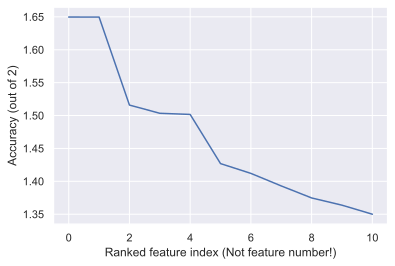

In [43]:
arr = []
for i in range(11):
    arr.append(truepos[largest_indices[i]])
plt.plot(arr)
plt.xlabel("Ranked feature index (Not feature number!)")
plt.ylabel("Accuracy (out of 2)")
plt.show()

In [11]:
for i in range(15):
    print('Features ', str(largest_indices[i]), '\n Confusion matrix \n',CM[:,:,largest_indices[i]])

Features  0 
 Confusion matrix 
 [[0.8781 0.1219]
 [0.2284 0.7716]]
Features  5 
 Confusion matrix 
 [[0.8612 0.1388]
 [0.2116 0.7884]]
Features  9 
 Confusion matrix 
 [[0.7806 0.2194]
 [0.2647 0.7353]]
Features  10 
 Confusion matrix 
 [[0.6981 0.3019]
 [0.1947 0.8053]]
Features  1 
 Confusion matrix 
 [[0.7706 0.2294]
 [0.2689 0.7311]]
Features  4 
 Confusion matrix 
 [[0.7137 0.2863]
 [0.2868 0.7132]]
Features  7 
 Confusion matrix 
 [[0.7262 0.2737]
 [0.3142 0.6858]]
Features  3 
 Confusion matrix 
 [[0.7188 0.2812]
 [0.3258 0.6742]]
Features  6 
 Confusion matrix 
 [[0.7431 0.2569]
 [0.3684 0.6316]]
Features  2 
 Confusion matrix 
 [[0.7169 0.2831]
 [0.3532 0.6468]]
Features  8 
 Confusion matrix 
 [[0.6931 0.3069]
 [0.3432 0.6568]]
Features  14 
 Confusion matrix 
 [[0. 0.]
 [0. 0.]]
Features  13 
 Confusion matrix 
 [[0. 0.]
 [0. 0.]]
Features  12 
 Confusion matrix 
 [[0. 0.]
 [0. 0.]]
Features  11 
 Confusion matrix 
 [[0. 0.]
 [0. 0.]]


In [12]:
CM_featuresRanked = np.zeros((2,2,15))
CM_featuresSTD = np.zeros((2,2,15))
for numKept in range(15):
    indices = largest_indices[:(numKept+1)]
    print('Using Features ', indices)
    try:
        manifolder = featureEmbedding(indices,data_raw,labels)
        CM_store = nearestNeighborClassification_repeated(manifolder, test_size)
        CM_featuresRanked[:,:,numKept] = np.mean(CM_store,axis=2)
        CM_featuresSTD[:,:,numKept] = np.std(CM_store,axis=2)
        print('\n\t Using ', str(numKept+1), ' Features Finished')
    except:
        print('\n\t Could not compute embedding do to eigendecomposition error')


Using Features  [0]
calculating histograms for snip  0  of  103  (dim  1  timeseries) . done
calculating histograms for snip  1  of  103  (dim  1  timeseries) . done
calculating histograms for snip  2  of  103  (dim  1  timeseries) . done
calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating histograms for snip  12  of  103  (dim  1  timeseries) . done
calculating histograms for s

computing local covariances for snip  8  of  103......... done
computing local covariances for snip  9  of  103......... done
computing local covariances for snip  10  of  103......... done
computing local covariances for snip  11  of  103......... done
computing local covariances for snip  12  of  103......... done
computing local covariances for snip  13  of  103......... done
computing local covariances for snip  14  of  103......... done
computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103......... done
computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  

calculating histograms for snip  22  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  23  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  24  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  25  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  26  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  27  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  28  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  29  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  30  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  31  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  32  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  33  of  103  (dim  2  timeseries) .. done
calculating histograms for snip  34  of  103  (dim  2  timeseries) .. done
calculating histograms fo

computing local covariances for snip  33  of  103......... done
computing local covariances for snip  34  of  103......... done
computing local covariances for snip  35  of  103......... done
computing local covariances for snip  36  of  103......... done
computing local covariances for snip  37  of  103......... done
computing local covariances for snip  38  of  103......... done
computing local covariances for snip  39  of  103......... done
computing local covariances for snip  40  of  103......... done
computing local covariances for snip  41  of  103......... done
computing local covariances for snip  42  of  103......... done
computing local covariances for snip  43  of  103......... done
computing local covariances for snip  44  of  103......... done
computing local covariances for snip  45  of  103......... done
computing local covariances for snip  46  of  103......... done
computing local covariances for snip  47  of  103......... done
computing local covariances for snip  48

calculating histograms for snip  42  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  43  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  44  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  45  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  46  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  47  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  48  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  49  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  50  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  51  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  52  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  53  of  103  (dim  3  timeseries) ... done
calculating histograms for snip  54  of  103  (dim  3  timeseries) ... done
calculating 

computing local covariances for snip  55  of  103......... done
computing local covariances for snip  56  of  103......... done
computing local covariances for snip  57  of  103......... done
computing local covariances for snip  58  of  103......... done
computing local covariances for snip  59  of  103......... done
computing local covariances for snip  60  of  103......... done
computing local covariances for snip  61  of  103......... done
computing local covariances for snip  62  of  103......... done
computing local covariances for snip  63  of  103......... done
computing local covariances for snip  64  of  103......... done
computing local covariances for snip  65  of  103......... done
computing local covariances for snip  66  of  103......... done
computing local covariances for snip  67  of  103......... done
computing local covariances for snip  68  of  103......... done
computing local covariances for snip  69  of  103......... done
computing local covariances for snip  70

calculating histograms for snip  60  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  61  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  62  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  63  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  64  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  65  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  66  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  67  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  68  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  69  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  70  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  71  of  103  (dim  4  timeseries) .... done
calculating histograms for snip  72  of  103  (dim  4  timeseries) .... done

computing local covariances for snip  76  of  103......... done
computing local covariances for snip  77  of  103......... done
computing local covariances for snip  78  of  103......... done
computing local covariances for snip  79  of  103......... done
computing local covariances for snip  80  of  103......... done
computing local covariances for snip  81  of  103......... done
computing local covariances for snip  82  of  103......... done
computing local covariances for snip  83  of  103......... done
computing local covariances for snip  84  of  103......... done
computing local covariances for snip  85  of  103......... done
computing local covariances for snip  86  of  103......... done
computing local covariances for snip  87  of  103......... done
computing local covariances for snip  88  of  103......... done
computing local covariances for snip  89  of  103......... done
computing local covariances for snip  90  of  103......... done
computing local covariances for snip  91

calculating histograms for snip  76  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  77  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  78  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  79  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  80  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  81  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  82  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  83  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  84  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  85  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  86  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  87  of  103  (dim  5  timeseries) ..... done
calculating histograms for snip  88  of  103  (dim  5  timeserie

computing local covariances for snip  95  of  103......... done
computing local covariances for snip  96  of  103......... done
computing local covariances for snip  97  of  103......... done
computing local covariances for snip  98  of  103......... done
computing local covariances for snip  99  of  103......... done
computing local covariances for snip  100  of  103......... done
computing local covariances for snip  101  of  103......... done
computing local covariances for snip  102  of  103......... done
using 4000 for variable m
computing Dis matrix ..........done!
aniostropic kernel ... Using partial symmetric eigensolver from scipy
done
extending embedding (building Psi) ... done

	 Program Executed in 147.42 seconds
0
4
2
0
1
1
0
0
0
0
1
0
0
0
0
1
0
2
1
1
0
0
0
2
1
2
0
1
0
0
0
0
3
0
1
0
1
0
0
1
1
0
0
1
0
0
0
3
0
1
0
0
1
0
0
0
0
1
3
3
0
0
1
0
0
1
0
1
0
0
1
4
0
0
1
0
1
0
0
4
0
1
0
0
0
0
0
0
0
0
0
2
0
0
0
1
0
1
0
0

	 Using  5  Features Finished
Using Features  [ 0  5  9 10  1  4

calculating histograms for snip  91  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  92  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  93  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  94  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  95  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  96  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  97  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  98  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  99  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  100  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  101  of  103  (dim  6  timeseries) ...... done
calculating histograms for snip  102  of  103  (dim  6  timeseries) ...... done
computing local covariances for snip  0  of  103.

calculating histograms for snip  2  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  3  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  4  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  5  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  6  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  7  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  8  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  9  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  10  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  11  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  12  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  13  of  103  (dim  7  timeseries) ....... done
calculating histograms for snip  14  of  103  (d

computing local covariances for snip  1  of  103......... done
computing local covariances for snip  2  of  103......... done
computing local covariances for snip  3  of  103......... done
computing local covariances for snip  4  of  103......... done
computing local covariances for snip  5  of  103......... done
computing local covariances for snip  6  of  103......... done
computing local covariances for snip  7  of  103......... done
computing local covariances for snip  8  of  103......... done
computing local covariances for snip  9  of  103......... done
computing local covariances for snip  10  of  103......... done
computing local covariances for snip  11  of  103......... done
computing local covariances for snip  12  of  103......... done
computing local covariances for snip  13  of  103......... done
computing local covariances for snip  14  of  103......... done
computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103

calculating histograms for snip  14  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  15  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  16  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  17  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  18  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  19  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  20  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  21  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  22  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  23  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  24  of  103  (dim  8  timeseries) ........ done
calculating histograms for snip  25  of  103  (dim  8  timeseries) ........ done
calculating histograms for s

computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103......... done
computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24  of  103......... done
computing local covariances for snip  25  of  103......... done
computing local covariances for snip  26  of  103......... done
computing local covariances for snip  27  of  103......... done
computing local covariances for snip  28  of  103......... done
computing local covariances for snip  29  of  103......... done
computing local covariances for snip  30

calculating histograms for snip  25  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  26  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  27  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  28  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  29  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  30  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  31  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  32  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  33  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  34  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  35  of  103  (dim  9  timeseries) ......... done
calculating histograms for snip  36  of  103  (dim  9  timeseries) ......... done
calculating hist

computing local covariances for snip  28  of  103......... done
computing local covariances for snip  29  of  103......... done
computing local covariances for snip  30  of  103......... done
computing local covariances for snip  31  of  103......... done
computing local covariances for snip  32  of  103......... done
computing local covariances for snip  33  of  103......... done
computing local covariances for snip  34  of  103......... done
computing local covariances for snip  35  of  103......... done
computing local covariances for snip  36  of  103......... done
computing local covariances for snip  37  of  103......... done
computing local covariances for snip  38  of  103......... done
computing local covariances for snip  39  of  103......... done
computing local covariances for snip  40  of  103......... done
computing local covariances for snip  41  of  103......... done
computing local covariances for snip  42  of  103......... done
computing local covariances for snip  43

calculating histograms for snip  34  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  35  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  36  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  37  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  38  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  39  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  40  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  41  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  42  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  43  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  44  of  103  (dim  10  timeseries) .......... done
calculating histograms for snip  45  of  103  (dim  10  timeseries) ........

computing local covariances for snip  37  of  103......... done
computing local covariances for snip  38  of  103......... done
computing local covariances for snip  39  of  103......... done
computing local covariances for snip  40  of  103......... done
computing local covariances for snip  41  of  103......... done
computing local covariances for snip  42  of  103......... done
computing local covariances for snip  43  of  103......... done
computing local covariances for snip  44  of  103......... done
computing local covariances for snip  45  of  103......... done
computing local covariances for snip  46  of  103......... done
computing local covariances for snip  47  of  103......... done
computing local covariances for snip  48  of  103......... done
computing local covariances for snip  49  of  103......... done
computing local covariances for snip  50  of  103......... done
computing local covariances for snip  51  of  103......... done
computing local covariances for snip  52

calculating histograms for snip  40  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  41  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  42  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  43  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  44  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  45  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  46  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  47  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  48  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  49  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  50  of  103  (dim  11  timeseries) ........... done
calculating histograms for snip  51  of  103  (dim  11  timeserie

computing local covariances for snip  44  of  103......... done
computing local covariances for snip  45  of  103......... done
computing local covariances for snip  46  of  103......... done
computing local covariances for snip  47  of  103......... done
computing local covariances for snip  48  of  103......... done
computing local covariances for snip  49  of  103......... done
computing local covariances for snip  50  of  103......... done
computing local covariances for snip  51  of  103......... done
computing local covariances for snip  52  of  103......... done
computing local covariances for snip  53  of  103......... done
computing local covariances for snip  54  of  103......... done
computing local covariances for snip  55  of  103......... done
computing local covariances for snip  56  of  103......... done
computing local covariances for snip  57  of  103......... done
computing local covariances for snip  58  of  103......... done
computing local covariances for snip  59

calculating histograms for snip  45  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  46  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  47  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  48  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  49  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  50  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  51  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  52  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  53  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  54  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  55  of  103  (dim  12  timeseries) ............ done
calculating histograms for snip  56  of  103  (dim  12

computing local covariances for snip  50  of  103......... done
computing local covariances for snip  51  of  103......... done
computing local covariances for snip  52  of  103......... done
computing local covariances for snip  53  of  103......... done
computing local covariances for snip  54  of  103......... done
computing local covariances for snip  55  of  103......... done
computing local covariances for snip  56  of  103......... done
computing local covariances for snip  57  of  103......... done
computing local covariances for snip  58  of  103......... done
computing local covariances for snip  59  of  103......... done
computing local covariances for snip  60  of  103......... done
computing local covariances for snip  61  of  103......... done
computing local covariances for snip  62  of  103......... done
computing local covariances for snip  63  of  103......... done
computing local covariances for snip  64  of  103......... done
computing local covariances for snip  65

calculating histograms for snip  49  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  50  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  51  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  52  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  53  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  54  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  55  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  56  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  57  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  58  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  59  of  103  (dim  13  timeseries) ............. done
calculating histograms for snip  60  of  10

computing local covariances for snip  54  of  103......... done
computing local covariances for snip  55  of  103......... done
computing local covariances for snip  56  of  103......... done
computing local covariances for snip  57  of  103......... done
computing local covariances for snip  58  of  103......... done
computing local covariances for snip  59  of  103......... done
computing local covariances for snip  60  of  103......... done
computing local covariances for snip  61  of  103......... done
computing local covariances for snip  62  of  103......... done
computing local covariances for snip  63  of  103......... done
computing local covariances for snip  64  of  103......... done
computing local covariances for snip  65  of  103......... done
computing local covariances for snip  66  of  103......... done
computing local covariances for snip  67  of  103......... done
computing local covariances for snip  68  of  103......... done
computing local covariances for snip  69

calculating histograms for snip  51  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  52  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  53  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  54  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  55  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  56  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  57  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  58  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  59  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  60  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip  61  of  103  (dim  14  timeseries) .............. done
calculating histograms for snip 

computing local covariances for snip  56  of  103......... done
computing local covariances for snip  57  of  103......... done
computing local covariances for snip  58  of  103......... done
computing local covariances for snip  59  of  103......... done
computing local covariances for snip  60  of  103......... done
computing local covariances for snip  61  of  103......... done
computing local covariances for snip  62  of  103......... done
computing local covariances for snip  63  of  103......... done
computing local covariances for snip  64  of  103......... done
computing local covariances for snip  65  of  103......... done
computing local covariances for snip  66  of  103......... done
computing local covariances for snip  67  of  103......... done
computing local covariances for snip  68  of  103......... done
computing local covariances for snip  69  of  103......... done
computing local covariances for snip  70  of  103......... done
computing local covariances for snip  71

calculating histograms for snip  52  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  53  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  54  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  55  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  56  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  57  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  58  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  59  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  60  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  61  of  103  (dim  15  timeseries) ............... done
calculating histograms for snip  62  of  103  (dim  15  timeseries) ............... done
calculating histogram

computing local covariances for snip  57  of  103......... done
computing local covariances for snip  58  of  103......... done
computing local covariances for snip  59  of  103......... done
computing local covariances for snip  60  of  103......... done
computing local covariances for snip  61  of  103......... done
computing local covariances for snip  62  of  103......... done
computing local covariances for snip  63  of  103......... done
computing local covariances for snip  64  of  103......... done
computing local covariances for snip  65  of  103......... done
computing local covariances for snip  66  of  103......... done
computing local covariances for snip  67  of  103......... done
computing local covariances for snip  68  of  103......... done
computing local covariances for snip  69  of  103......... done
computing local covariances for snip  70  of  103......... done
computing local covariances for snip  71  of  103......... done
computing local covariances for snip  72

In [13]:
for i in range(15):
    print('Features ', str(largest_indices[:(i+1)]), '\n Confusion matrix \n',CM_featuresRanked[:,:,i])

Features  [0] 
 Confusion matrix 
 [[0.8888 0.1113]
 [0.2342 0.7658]]
Features  [0 5] 
 Confusion matrix 
 [[0.8425 0.1575]
 [0.1816 0.8184]]
Features  [0 5 9] 
 Confusion matrix 
 [[0.8688 0.1313]
 [0.1984 0.8016]]
Features  [ 0  5  9 10] 
 Confusion matrix 
 [[0.815  0.185 ]
 [0.2353 0.7647]]
Features  [ 0  5  9 10  1] 
 Confusion matrix 
 [[0.8631 0.1369]
 [0.23   0.77  ]]
Features  [ 0  5  9 10  1  4] 
 Confusion matrix 
 [[0.865  0.135 ]
 [0.2053 0.7947]]
Features  [ 0  5  9 10  1  4  7] 
 Confusion matrix 
 [[0.8144 0.1856]
 [0.2279 0.7721]]
Features  [ 0  5  9 10  1  4  7  3] 
 Confusion matrix 
 [[0.7581 0.2419]
 [0.1484 0.8516]]
Features  [ 0  5  9 10  1  4  7  3  6] 
 Confusion matrix 
 [[0.8225 0.1775]
 [0.17   0.83  ]]
Features  [ 0  5  9 10  1  4  7  3  6  2] 
 Confusion matrix 
 [[0.8125 0.1875]
 [0.2263 0.7737]]
Features  [ 0  5  9 10  1  4  7  3  6  2  8] 
 Confusion matrix 
 [[0.6881 0.3119]
 [0.2184 0.7816]]
Features  [ 0  5  9 10  1  4  7  3  6  2  8 14] 
 Confusion 

In [19]:
class EmptyObject:
    pass

results = EmptyObject()
results.CM = CM
results.truepos = truepos
results.CM_featuresRanked = CM_featuresRanked
results.CM_featuresSTD = CM_featuresSTD
import pickle
try:
    pfile = open("classificationResults.pickle", "wb")
    pickle.dump(results, pfile)
    pfile.close()
    print("Pickle file written successfully")
except:
    print("Unable to write pickle file")

Pickle file written successfully


In [21]:
import pickle
try:
    pfile = open("classificationResults.pickle", "rb")
    results = pickle.load(pfile)
    pfile.close()
    print("Pickle file read successfully")
except Exception as ex:
    print(ex)
    print("Unable to read pickle file")

Pickle file read successfully


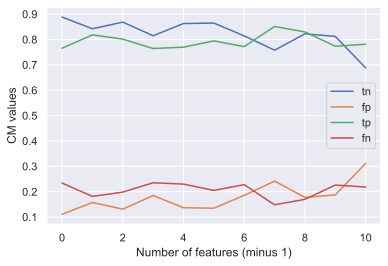

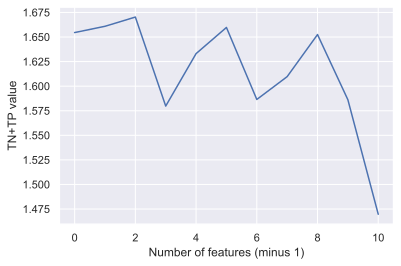

In [50]:
#print(results.CM)
#print(results.CM.shape)

tnArr = results.CM_featuresRanked[0,0,:11]
fpArr = results.CM_featuresRanked[0,1,:11]
tpArr = results.CM_featuresRanked[1,1,:11]
fnArr = results.CM_featuresRanked[1,0,:11]

plt.plot(tnArr, label="tn")
plt.plot(fpArr, label="fp")
plt.plot(tpArr, label="tp")
plt.plot(fnArr, label="fn")
plt.legend()
plt.xlabel("Number of features (minus 1)")
plt.ylabel("CM values")
plt.show()

correctCount = np.add(tnArr, tpArr)
plt.plot(correctCount)
plt.xlabel("Number of features (minus 1)")
plt.ylabel("TN+TP value")
plt.show()

In [ ]:
tnArr = results.CM_featuresSTD[0,0,:11]
fpArr = results.CM_featuresSTD[0,1,:11]
tpArr = results.CM_featuresSTD[1,1,:11]
fnArr = results.CM_featuresSTD[1,0,:11]
print(tnArr)
print(fpArr)
print(tpArr)
print(fnArr)
plt.plot(tnArr, label="tn")
plt.plot(fpArr, label="fp")
plt.plot(tpArr, label="tp")
plt.plot(fnArr, label="fn")
plt.legend()
plt.show()

# Nearest Neighbor quantile prediction of locallabel

In [ ]:
test_size = .33
CM = np.zeros((2,2,15))
for featInd in range(15):
    try:
        manifolder = featureEmbedding([featInd],data_raw,labels)
        CM_store, params_store = nearestNeighborQuantile_repeated(manifolder, test_size, numIter=100)
        CM[:,:,featInd] = np.mean(CM_store,axis=2)
        print(params_store)
        print('\n\t Feature ', str(featInd), ' Finished')
    except:
        print('\n\t Could not compute embedding do to eigendecomposition error')
    

calculating histograms for snip  0  of  103  (dim  1  timeseries) . done
calculating histograms for snip  1  of  103  (dim  1  timeseries) . done
calculating histograms for snip  2  of  103  (dim  1  timeseries) . done
calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating histograms for snip  12  of  103  (dim  1  timeseries) . done
calculating histograms for snip  13  of  103  (d

Iter  57 parameters,  (3, 1, 5.62)
Iter  58 parameters,  (2, 1, 4.12)
Iter  59 parameters,  (5, 1, 6.99)
Iter  60 parameters,  (3, 1, 4.81)
Iter  61 parameters,  (5, 2, 2.99)
Iter  62 parameters,  (2, 1, 2.99)
Iter  63 parameters,  (6, 2, 3.96)
Iter  64 parameters,  (2, 1, 2.11)
Iter  65 parameters,  (2, 1, 2.85)
Iter  66 parameters,  (4, 2, 1.6)
Iter  67 parameters,  (2, 1, 2.51)
Iter  68 parameters,  (4, 1, 4.17)
Iter  69 parameters,  (5, 2, 2.09)
Iter  70 parameters,  (4, 2, 1.77)
Iter  71 parameters,  (5, 2, 2.59)
Iter  72 parameters,  (24, 2, 14.85)
Iter  73 parameters,  (3, 1, 4.15)
Iter  74 parameters,  (4, 1, 6.68)
Iter  75 parameters,  (6, 1, 9.38)
Iter  76 parameters,  (4, 1, 5.15)
Iter  77 parameters,  (6, 2, 2.62)
Iter  78 parameters,  (3, 2, 0.68)
Iter  79 parameters,  (3, 1, 4.4)
Iter  80 parameters,  (1, 1, 1.65)
Iter  81 parameters,  (3, 1, 3.64)
Iter  82 parameters,  (2, 1, 1.09)
Iter  83 parameters,  (7, 3, 2.4)
Iter  84 parameters,  (9, 3, 7.75)
Iter  85 parameters, 

computing local covariances for snip  79  of  103......... done
computing local covariances for snip  80  of  103......... done
computing local covariances for snip  81  of  103......... done
computing local covariances for snip  82  of  103......... done
computing local covariances for snip  83  of  103......... done
computing local covariances for snip  84  of  103......... done
computing local covariances for snip  85  of  103......... done
computing local covariances for snip  86  of  103......... done
computing local covariances for snip  87  of  103......... done
computing local covariances for snip  88  of  103......... done
computing local covariances for snip  89  of  103......... done
computing local covariances for snip  90  of  103......... done
computing local covariances for snip  91  of  103......... done
computing local covariances for snip  92  of  103......... done
computing local covariances for snip  93  of  103......... done
computing local covariances for snip  94

computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24  of  103......... done
computing local covariances for snip  25  of  103......... done
computing local covariances for snip  26  of  103......... done
computing local covariances for snip  27  of  103......... done
computing local covariances for snip  28  of  103......... done
computing local covariances for snip  29  of  103......... done
computing local covariances for snip  30  of  103......... done
computing local covariances for snip  31  of  103......... done
computing local covariances for snip  32  of  103......... done
computing local covariances for snip  33  of  103......... done
computing local covariances for snip  34  of  103......... done
computing local covariances for snip  35

Iter  75 parameters,  (12, 6, 0.84)
Iter  76 parameters,  (16, 3, 8.95)
Iter  77 parameters,  (21, 5, 5.42)
Iter  78 parameters,  (19, 5, 2.2)
Iter  79 parameters,  (4, 1, 11.56)
Iter  80 parameters,  (18, 5, 3.64)
Iter  81 parameters,  (21, 5, 5.03)
Iter  82 parameters,  (14, 6, 1.94)
Iter  83 parameters,  (4, 1, 5.29)
Iter  84 parameters,  (8, 4, 5.33)
Iter  85 parameters,  (13, 6, 1.56)
Iter  86 parameters,  (1, 1, 0.77)
Iter  87 parameters,  (4, 1, 5.38)
Iter  88 parameters,  (12, 4, 2.74)
Iter  89 parameters,  (16, 5, 3.4)
Iter  90 parameters,  (19, 6, 3.61)
Iter  91 parameters,  (21, 8, 2.02)
Iter  92 parameters,  (15, 3, 5.6)
Iter  93 parameters,  (3, 2, 6.04)
Iter  94 parameters,  (24, 8, 3.03)
Iter  95 parameters,  (17, 6, 2.65)
Iter  96 parameters,  (20, 7, 2.73)
Iter  97 parameters,  (16, 4, 4.93)
Iter  98 parameters,  (18, 7, 1.71)
Iter  99 parameters,  (18, 5, 4.94)
[[11.    4.    1.72]
 [21.    9.    0.84]
 [ 9.    3.    3.73]
 [11.    5.    1.12]
 [23.    8.    2.11]
 [2

computing local covariances for snip  90  of  103......... done
computing local covariances for snip  91  of  103......... done
computing local covariances for snip  92  of  103......... done
computing local covariances for snip  93  of  103......... done
computing local covariances for snip  94  of  103......... done
computing local covariances for snip  95  of  103......... done
computing local covariances for snip  96  of  103......... done
computing local covariances for snip  97  of  103......... done
computing local covariances for snip  98  of  103......... done
computing local covariances for snip  99  of  103......... done
computing local covariances for snip  100  of  103......... done
computing local covariances for snip  101  of  103......... done
computing local covariances for snip  102  of  103......... done
using 4000 for variable m
computing Dis matrix ..........done!
aniostropic kernel ... 

..\manifolder\main.py:461: RuntimeWarning: divide by zero encountered in true_divide
  A = np.exp(-Dis / (4 * ep))
..\manifolder\main.py:461: RuntimeWarning: invalid value encountered in true_divide
  A = np.exp(-Dis / (4 * ep))
..\manifolder\main.py:462: RuntimeWarning: invalid value encountered in matmul
  W_sml = A.T @ A


Using partial symmetric eigensolver from scipy

	 Could not compute embedding do to eigendecomposition error
calculating histograms for snip  0  of  103  (dim  1  timeseries) . done
calculating histograms for snip  1  of  103  (dim  1  timeseries) . done
calculating histograms for snip  2  of  103  (dim  1  timeseries) . done
calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating h

Iter  52 parameters,  (1, 1, 2.02)
Iter  53 parameters,  (4, 1, 8.21)
Iter  54 parameters,  (3, 1, 8.26)
Iter  55 parameters,  (4, 1, 9.31)
Iter  56 parameters,  (1, 1, 3.22)
Iter  57 parameters,  (18, 3, 10.68)
Iter  58 parameters,  (4, 1, 7.63)
Iter  59 parameters,  (11, 1, 12.94)
Iter  60 parameters,  (7, 1, 10.77)
Iter  61 parameters,  (20, 6, 6.16)
Iter  62 parameters,  (4, 1, 9.44)
Iter  63 parameters,  (6, 1, 9.04)
Iter  64 parameters,  (3, 1, 6.64)
Iter  65 parameters,  (13, 3, 7.32)
Iter  66 parameters,  (3, 1, 6.93)
Iter  67 parameters,  (9, 2, 6.95)
Iter  68 parameters,  (10, 2, 9.02)
Iter  69 parameters,  (2, 1, 4.39)
Iter  70 parameters,  (17, 4, 6.52)
Iter  71 parameters,  (12, 3, 5.48)
Iter  72 parameters,  (13, 3, 7.89)
Iter  73 parameters,  (17, 3, 9.35)
Iter  74 parameters,  (3, 1, 7.61)
Iter  75 parameters,  (4, 1, 9.4)
Iter  76 parameters,  (3, 1, 7.6)
Iter  77 parameters,  (2, 1, 4.95)
Iter  78 parameters,  (17, 3, 9.35)
Iter  79 parameters,  (23, 3, 12.56)
Iter  8

computing local covariances for snip  77  of  103......... done
computing local covariances for snip  78  of  103......... done
computing local covariances for snip  79  of  103......... done
computing local covariances for snip  80  of  103......... done
computing local covariances for snip  81  of  103......... done
computing local covariances for snip  82  of  103......... done
computing local covariances for snip  83  of  103......... done
computing local covariances for snip  84  of  103......... done
computing local covariances for snip  85  of  103......... done
computing local covariances for snip  86  of  103......... done
computing local covariances for snip  87  of  103......... done
computing local covariances for snip  88  of  103......... done
computing local covariances for snip  89  of  103......... done
computing local covariances for snip  90  of  103......... done
computing local covariances for snip  91  of  103......... done
computing local covariances for snip  92

computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24  of  103......... done
computing local covariances for snip  25  of  103......... done
computing local covariances for snip  26  of  103......... done
computing local covariances for snip  27  of  103......... done
computing local covariances for snip  28  of  103......... done
computing local covariances for snip  29  of  103......... done
computing local covariances for snip  30  of  103......... done
computing local covariances for snip  31  of  103......... done
computing local covariances for snip  32  of  103......... done
computing local covariances for snip  33

Iter  72 parameters,  (9, 1, 10.68)
Iter  73 parameters,  (8, 2, 7.23)
Iter  74 parameters,  (6, 1, 8.09)
Iter  75 parameters,  (9, 3, 1.86)
Iter  76 parameters,  (7, 3, 2.42)
Iter  77 parameters,  (19, 6, 3.83)
Iter  78 parameters,  (4, 1, 8.36)
Iter  79 parameters,  (15, 4, 4.88)
Iter  80 parameters,  (13, 4, 3.29)
Iter  81 parameters,  (9, 5, 1.14)
Iter  82 parameters,  (5, 3, 1.24)
Iter  83 parameters,  (15, 5, 4.06)
Iter  84 parameters,  (12, 2, 8.41)
Iter  85 parameters,  (17, 5, 3.67)
Iter  86 parameters,  (7, 3, 2.2)
Iter  87 parameters,  (12, 2, 8.23)
Iter  88 parameters,  (6, 1, 10.51)
Iter  89 parameters,  (19, 6, 4.35)
Iter  90 parameters,  (6, 1, 7.99)
Iter  91 parameters,  (13, 2, 9.17)
Iter  92 parameters,  (11, 3, 6.27)
Iter  93 parameters,  (18, 6, 3.62)
Iter  94 parameters,  (1, 1, 2.22)
Iter  95 parameters,  (10, 2, 9.16)
Iter  96 parameters,  (12, 4, 3.53)
Iter  97 parameters,  (5, 1, 8.64)
Iter  98 parameters,  (12, 4, 3.63)
Iter  99 parameters,  (16, 4, 6.72)
[[ 8

computing local covariances for snip  87  of  103......... done
computing local covariances for snip  88  of  103......... done
computing local covariances for snip  89  of  103......... done
computing local covariances for snip  90  of  103......... done
computing local covariances for snip  91  of  103......... done
computing local covariances for snip  92  of  103......... done
computing local covariances for snip  93  of  103......... done
computing local covariances for snip  94  of  103......... done
computing local covariances for snip  95  of  103......... done
computing local covariances for snip  96  of  103......... done
computing local covariances for snip  97  of  103......... done
computing local covariances for snip  98  of  103......... done
computing local covariances for snip  99  of  103......... done
computing local covariances for snip  100  of  103......... done
computing local covariances for snip  101  of  103......... done
computing local covariances for snip  

computing local covariances for snip  28  of  103......... done
computing local covariances for snip  29  of  103......... done
computing local covariances for snip  30  of  103......... done
computing local covariances for snip  31  of  103......... done
computing local covariances for snip  32  of  103......... done
computing local covariances for snip  33  of  103......... done
computing local covariances for snip  34  of  103......... done
computing local covariances for snip  35  of  103......... done
computing local covariances for snip  36  of  103......... done
computing local covariances for snip  37  of  103......... done
computing local covariances for snip  38  of  103......... done
computing local covariances for snip  39  of  103......... done
computing local covariances for snip  40  of  103......... done
computing local covariances for snip  41  of  103......... done
computing local covariances for snip  42  of  103......... done
computing local covariances for snip  43

Iter  89 parameters,  (24, 8, 3.23)
Iter  90 parameters,  (17, 3, 11.8)
Iter  91 parameters,  (24, 7, 4.92)
Iter  92 parameters,  (17, 5, 7.73)
Iter  93 parameters,  (8, 2, 6.79)
Iter  94 parameters,  (6, 3, 2.25)
Iter  95 parameters,  (13, 3, 6.66)
Iter  96 parameters,  (17, 3, 14.65)
Iter  97 parameters,  (6, 2, 4.23)
Iter  98 parameters,  (8, 3, 3.02)
Iter  99 parameters,  (24, 7, 4.92)
[[15.    3.   10.28]
 [23.    6.    8.96]
 [ 7.    3.    3.25]
 [10.    4.    4.41]
 [ 6.    3.    2.11]
 [20.    6.    4.8 ]
 [18.    3.   13.35]
 [24.    8.    3.46]
 [11.    3.    6.19]
 [18.    3.   12.59]
 [18.    3.   13.08]
 [10.    2.    8.57]
 [23.    4.   12.56]
 [22.    5.   10.03]
 [24.    4.   11.78]
 [ 7.    2.    6.3 ]
 [ 4.    2.    3.63]
 [ 1.    1.    3.5 ]
 [11.    3.    8.58]
 [17.    3.   11.55]
 [ 6.    2.    4.62]
 [13.    2.   12.74]
 [14.    3.    9.93]
 [18.    4.    8.1 ]
 [ 8.    2.    9.01]
 [ 5.    2.    3.21]
 [ 6.    2.    4.56]
 [22.    8.    2.86]
 [ 2.    2.    0.99

computing local covariances for snip  96  of  103......... done
computing local covariances for snip  97  of  103......... done
computing local covariances for snip  98  of  103......... done
computing local covariances for snip  99  of  103......... done
computing local covariances for snip  100  of  103......... done
computing local covariances for snip  101  of  103......... done
computing local covariances for snip  102  of  103......... done
using 4000 for variable m
computing Dis matrix ..........done!
aniostropic kernel ... Using partial symmetric eigensolver from scipy
done
extending embedding (building Psi) ... done

	 Program Executed in 18.48 seconds
Iter  0 parameters,  (4, 2, 3.14)
Iter  1 parameters,  (1, 1, 2.31)
Iter  2 parameters,  (18, 3, 12.21)
Iter  3 parameters,  (4, 2, 2.0)
Iter  4 parameters,  (7, 3, 2.28)
Iter  5 parameters,  (6, 2, 4.96)
Iter  6 parameters,  (18, 2, 12.44)
Iter  7 parameters,  (2, 2, 0.61)
Iter  8 parameters,  (24, 4, 14.65)
Iter  9 parameters,

calculating histograms for snip  25  of  103  (dim  1  timeseries) . done
calculating histograms for snip  26  of  103  (dim  1  timeseries) . done
calculating histograms for snip  27  of  103  (dim  1  timeseries) . done
calculating histograms for snip  28  of  103  (dim  1  timeseries) . done
calculating histograms for snip  29  of  103  (dim  1  timeseries) . done
calculating histograms for snip  30  of  103  (dim  1  timeseries) . done
calculating histograms for snip  31  of  103  (dim  1  timeseries) . done
calculating histograms for snip  32  of  103  (dim  1  timeseries) . done
calculating histograms for snip  33  of  103  (dim  1  timeseries) . done
calculating histograms for snip  34  of  103  (dim  1  timeseries) . done
calculating histograms for snip  35  of  103  (dim  1  timeseries) . done
calculating histograms for snip  36  of  103  (dim  1  timeseries) . done
calculating histograms for snip  37  of  103  (dim  1  timeseries) . done
calculating histograms for snip  38  o

In [ ]:
truepos = np.zeros(15)
for i in range(15):
    truepos[i] = CM[0,0,i] + CM[1,1,i]
    
n = 15
ranked = np.argsort(truepos)
largest_indices = ranked[::-1][:n]

print(largest_indices)

In [ ]:
for i in range(15):
    print('Features ', str(largest_indices[i]), '\n Confusion matrix \n',CM[:,:,largest_indices[i]])

In [ ]:
CM_featuresRanked = np.zeros((2,2,15))
CM_featuresSTD = np.zeros((2,2,15))
for numKept in range(15):
    indices = largest_indices[:(numKept+1)]
    print('Using Features ', indices)
    try:
        manifolder = featureEmbedding(indices,data_raw,labels)
        CM_store, params_store = nearestNeighborQuantile_repeated(manifolder, test_size, numIters=100)
        CM_featuresRanked[:,:,numKept] = np.mean(CM_store,axis=2)
        CM_featuresSTD[:,:,numKept] = np.std(CM_store,axis=2)
        print(params_store)
        print('\n\t Using ', str(numKept+1), ' Features Finished')
    except:
        print('\n\t Could not compute embedding do to eigendecomposition error')


In [ ]:
for i in range(15):
    print('Features ', str(largest_indices[:(i+1)]), '\n Confusion matrix \n',CM_featuresRanked[:,:,i], '\n STD \n', CM_featuresSTD[:,:,i])

In [ ]:
results = lambda: None #creates an empty object that we can modify
results.CM = CM
results.truepos = truepos
results.CM_featuresRanked = CM_featuresRanked
results.CM_featuresSTD = CM_featuresSTD
import pickle
try:
    pfile = open("quantileResults.pickle", "wb")
    pickle.dump(results, pfile)
    pfile.close()
    print("Pickle file written successfully")
except:
    print("Unable to write pickle file")

# Extra code

In [40]:
dist = sklearn.metrics.pairwise_distances(Psi,X_train)
inds = np.argsort(dist,axis=1)

pred_all = np.median(y_train[inds[:,0:knn]],axis=1)
pred_all_class = pred_all.astype(int) 


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(6592, 4)

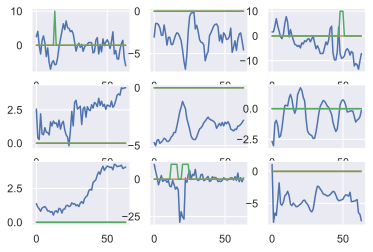

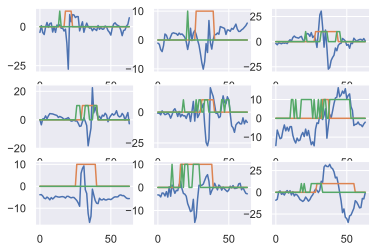

In [41]:
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_0[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_0[i]])
    
plt.show()
 
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_1[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_1[i]])

    
plt.show()

# Network prediction of locallabel with snippet level splits

In [42]:
import tensorflow as tf

model_snippet = tf.keras.Sequential([
    tf.keras.Input(shape=(manifolder.Dim,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


# Compile the model
model_snippet.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam')


In [43]:
# Fit data to model
history = model_snippet.fit(X_train, y_train,
            batch_size=32,
            epochs=50,
            class_weight=class_weight,
            verbose=1)

  ...
    to  
  ['...']
Train on 4352 samples
Epoch 1/50
4352/4352 [==============================] - 1s 115us/sample - loss: 1.1982
Epoch 2/50
4352/4352 [==============================] - 0s 27us/sample - loss: 0.9519
Epoch 3/50
4352/4352 [==============================] - 0s 26us/sample - loss: 0.8660
Epoch 4/50
4352/4352 [==============================] - 0s 29us/sample - loss: 0.8051
Epoch 5/50
4352/4352 [==============================] - 0s 35us/sample - loss: 0.7641
Epoch 6/50
4352/4352 [==============================] - 0s 29us/sample - loss: 0.7451
Epoch 7/50
4352/4352 [==============================] - 0s 28us/sample - loss: 0.7364
Epoch 8/50
4352/4352 [==============================] - 0s 28us/sample - loss: 0.7238
Epoch 9/50
4352/4352 [==============================] - 0s 27us/sample - loss: 0.7154
Epoch 10/50
4352/4352 [==============================] - 0s 26us/sample - loss: 0.7076
Epoch 11/50
4352/4352 [==============================] - 0s 26us/sample - loss: 0.7031
Epoc

In [44]:
prediction = model_snippet.predict(X_test)
predict_class = np.argmax(prediction, axis=1)

CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
print('Window Level Confusion:')
print(CM)


Window Level Confusion:
[[1598  383]
 [  38  221]]


[0.1463 0.1463 0.1463 0.1025 0.1025 0.1025 0.1025 0.1025 0.0789 0.0789
 0.0789 0.0789 0.0789 0.0811 0.0571 0.0571 0.0571 0.0312 0.0322 0.0333
 0.0357 0.     0.     0.     0.    ]
[0.8886 0.8886 0.8886 0.8962 0.8962 0.8962 0.8962 0.8962 0.8997 0.8997
 0.8997 0.8997 0.8997 0.8707 0.8482 0.8482 0.8482 0.8053 0.7836 0.763
 0.7248 0.7141 0.7141 0.7141 0.6817]


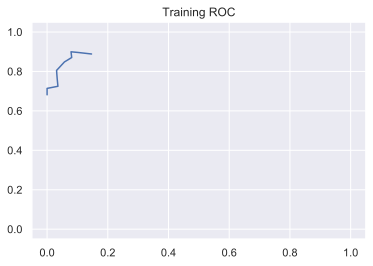

In [45]:
pred_train = model_snippet.predict(X_train)
pred_train_class = np.argmax(pred_train, axis=1)

falsepos = np.zeros(25)
truepos = np.zeros(25)
for threshold in range(25):
    numsnips = n_train_0 + n_train_1
    npts = X_train.shape[0]//(numsnips)
    y_snippet = y_train.reshape(numsnips,numpts)
    prediction_snippet = pred_train_class.reshape(numsnips,numpts)

    snippet_true = np.sum(y_snippet,axis=1) > 0
    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
    
    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    falsepos[threshold] = CM[0,1]/(np.sum(CM[:,1])+.01)
    truepos[threshold] = CM[0,0]/(np.sum(CM[:,0])+.01)
    
plt.plot(falsepos,truepos)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)
plt.title('Training ROC')
print(falsepos)
print(truepos)

Snippet Level Confusion:
[[14  2]
 [ 0 19]]


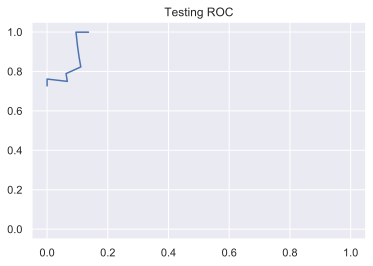

In [46]:
thresholdFromTrain=11

falsepos = np.zeros(25)
truepos = np.zeros(25)
for threshold in range(25):
    numsnips = (num_snips_0-(n_train_0+n_val_0)) + (num_snips_1-(n_train_1+n_val_1))
    numpts = (predict_class.shape[0])//numsnips
    
    prediction_snippet = predict_class.reshape(numsnips,numpts)
    y_snippet = y_test.reshape(numsnips,numpts)

    snippet_true = np.sum(y_snippet,axis=1) > 0
    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
    
    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    falsepos[threshold] = CM[0,1]/(np.sum(CM[:,1])+.01)
    truepos[threshold] = CM[0,0]/(np.sum(CM[:,0])+.01)
    
plt.plot(falsepos,truepos)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)
plt.title('Testing ROC')

snippet_true = np.sum(y_snippet,axis=1) > 0
snippet_predict = np.sum(prediction_snippet,axis=1) > thresholdFromTrain 
CM_test = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )

print('Snippet Level Confusion:')
print(CM_test)

In [47]:
pred_all = model_snippet.predict(Psi)
pred_all_class = np.argmax(pred_all, axis=1)


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(6592, 4)

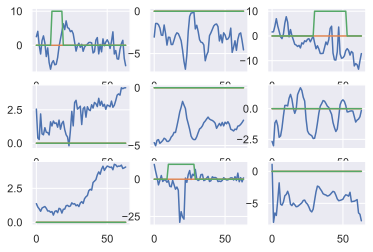

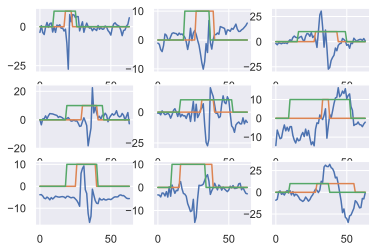

In [48]:
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_0[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_0[i]])
    
plt.show()
 
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_1[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_1[i]])

    
plt.show()

In [131]:
np.savetxt('astro_deep_learning_snippetSplit.csv', z_downsample, delimiter=',', fmt='%f')